# Water Quality Parameters Maps (CHL, TSM) - Coregistration¶

In [1]:
# Styling notebook

# System
import os
import sys

# Import scripts libraries for the project
sys.path.append('./src/python')

# Import the function to update the notebook style
from nbConfig import (css_styling)

css_styling()

## 0. Import libraries

Import the required libraries and setup the current working directories.

In [2]:
# Data
import numpy as np
import pandas as pd

# Spatial Data
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import richdem as rd

# Data visualization
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

# Import custom libraries
import wqpFunctions as wqp

In [3]:
# Current Working Directories
cwd = {
    'local': '.',
    'in': './in/data/wqp/S3',
    'out': './out/Coregistration',
    'vector': './vector',
}

In [4]:
os.path.join(cwd['in'],'simile_laghi_extent/simile_laghi_extent_600m_buff.shp')

'./in/data/wqp/S3\\simile_laghi_extent/simile_laghi_extent_600m_buff.shp'

Text(0.5, 1.0, 'Lakes shape and mask for data processing')

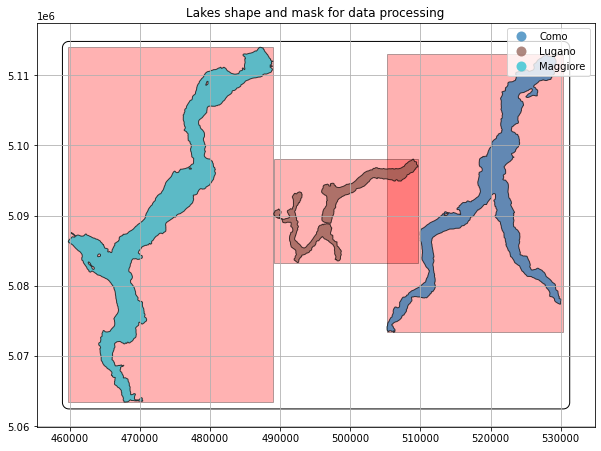

In [5]:
# Lakes shapes and mask
featureLakes = os.path.join(cwd['vector'],'simile_laghi/simile_laghi.shp')
featureGeometry = os.path.join(cwd['vector'],'simile_laghi_extent/simile_laghi_extent_600m_buff.shp')
featureBoxes = os.path.join(cwd['vector'],'simile_laghi_bboxes/simile_laghi_bboxes.shp')
# DataFrame of the lakes and mask
gdf_maskWQP = gpd.read_file(featureGeometry)
gdf_lakesWQP = gpd.read_file(featureLakes)
gdf_bboxesWQP = gpd.read_file(featureBoxes)
# Visualization of the lakes and mask
fig, ax = plt.subplots(figsize=(10, 10))
gdf_maskWQP.plot(ax = ax, color='white',edgecolor='k', alpha=1)
gdf_bboxesWQP.plot(ax = ax, color='red',edgecolor='k', alpha=0.3)
gdf_lakesWQP.plot(column='Nome', ax = ax ,edgecolor='k', alpha=0.7, legend=True)
ax.grid()
ax.set_title('Lakes shape and mask for data processing')

In [6]:
# Paths for the outputs of the master band

# Input Master Reference Band
master_name = 'S3A_IT_20190315T094218_L1'
oa_bands_master = os.path.join(cwd['in'], 'oa', master_name+'.tif')

# Output Master Reference Band - Masked to the extent of the lakes
out_path_master = os.path.join(cwd['out'], 'master', 'oa_18/full')

# Output Master Slope Reference Band
out_path_master_slope = os.path.join(cwd['out'], 'master', 'slope_oa_18/full')

In [7]:
# Master Band - Read Dataset and Crop by Features
master = wqp.wqp(oa_bands_master)
master.readWQP()
# Save Master Band
ref_band = 18
master.cropRasterByFeatures(featureGeometry,'Nome')
master.saveMaskedImage(os.path.join(out_path_master,master.name+'_Oa_18.tif'),'wqp',band=ref_band)

Text(0.5, 1.0, 'Master Band for Coregistraton - S3A_IT_20190315T094218_L1')

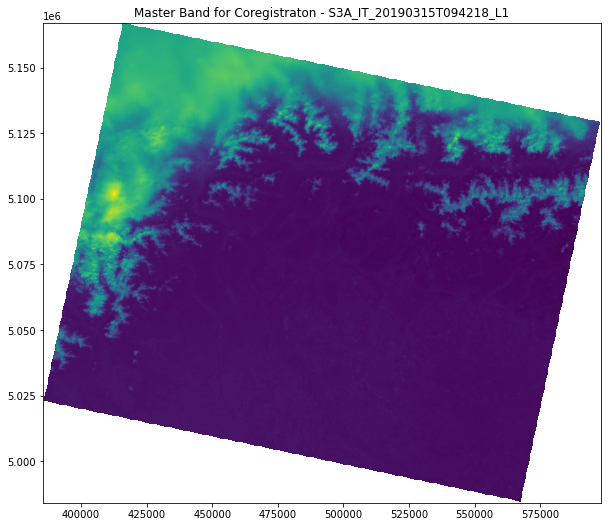

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = rasterio.plot.show((master.image, 1), ax=ax, cmap='viridis')
ax.set_title('Master Band for Coregistraton - {}'.format(master_name))

In [9]:
# Read Master Band - Compute and Save Slope Estimates
rd_master = rd.LoadGDAL(os.path.join(out_path_master,master.name+'_Oa_18.tif'), no_data=0)
slope_master = rd.TerrainAttribute(rd_master, attrib='slope_riserun')
slope_master
rd.SaveGDAL(os.path.join(out_path_master_slope,master.name+'_Oa_18.tif'), slope_master)

In [10]:
# Read Reference Band Slope - Crop the slope estimates in the different lakes
slope_master = wqp.wqp(os.path.join(out_path_master_slope,master_name+'_Oa_18.tif'))
slope_master.readWQP()
slope_master.cropRasterByFeatures(featureLakes, 'Nome')
for nameFeature in list(gdf_bboxesWQP.Nome):
    out_path = os.path.join(cwd['out'],'master','slope_oa_18\\partial','{}\\{}'.format(nameFeature,master_name+'_Oa_18.tif'))
    slope_master.saveMaskedImage(out_path,nameFeature, band=1)

## 1. Coregistration

### 1.1. Images subsets - Radiance Reference Band - Slope

In [11]:
#Spatial analysis
import richdem as rd

Master Image

In [12]:
# Define the reference (master) raster for the corregistration algorithm
oa_bands_master =  os.path.join(cwd['in'],'oa','S3A_IT_20190315T094218_L1.tif')
master = wqp.wqp(oa_bands_master)
master.readWQP()
# Mask layer for creating he subsets
featureGeometry = './vector/simile_laghi_extent/simile_laghi_extent_1500m_buff.shp'
# Cropped master raster
master.cropRasterByFeatures(featureGeometry,'Nome')
# Export masked master dataset
out_path_master = os.path.join(cwd['out'],'master/oa_18')
master.saveMaskedImage(os.path.join(out_path_master,'full',master.name+'_Oa_18.tif'),'wqp',band=18)
# Generate the slope layer for the master dataset
out_path_master_slope = os.path.join(cwd['out'],'master/slope_oa_18')
rd_master = rd.LoadGDAL(os.path.join(out_path_master_slope,'full',master.name+'_Oa_18.tif'), no_data=0)
slope_master = rd.TerrainAttribute(rd_master, attrib='slope_riserun')
# Save the computed slope dataset
rd.SaveGDAL(os.path.join(out_path_master_slope,'full',master.name+'_Oa_18.tif'), slope_master)

Slave images

In [13]:
# Output folder for the slave image
out_path_slave = os.path.join(cwd['out'],'slave/oa_18')
out_path_slave_slope = os.path.join(cwd['out'],'slave/slope_oa_18')
# Apply the mask to the coregistered (slave) images
for root, dirs, files in os.walk(os.path.join('in','data/wqp/s3/oa')):
    for f in files:
        if f.endswith('.tif'):
            oa_bands_slave = os.path.join(root,f)
            slave = wqp.wqp(oa_bands_slave)
            slave.readWQP()
            slave.cropRasterByFeatures(featureGeometry,'Nome')
            slave.saveMaskedImage(os.path.join(out_path_slave,'full',slave.name+'_Oa_18.tif'),'wqp',band=18)
            rd_slave = rd.LoadGDAL(os.path.join(out_path_slave,'full',slave.name+'_Oa_18.tif'), no_data=0)
            slope_slave = rd.TerrainAttribute(rd_slave, attrib='slope_riserun')
            rd.SaveGDAL(os.path.join(out_path_slave_slope,'full',slave.name+'_Oa_18.tif'), slope_slave)
            for nameFeature in list(gdf_bboxesWQP.Nome):
                slope_slave = wqp.wqp(os.path.join(out_path_slave_slope,'full',slave.name+'_Oa_18.tif'))
                slope_slave.readWQP()
                slope_slave.cropRasterByFeatures(featureLakes, 'Nome')
                out_path = os.path.join(out_path_slave_slope,'partial',nameFeature,slave.name+'_Oa_18.tif')
                slope_slave.saveMaskedImage(out_path,nameFeature, band=1)

### 1.3. Subset WQP - sample maps

In [24]:
# Output folder for the slave image
out_path = os.path.join('.\\in\\\data\\wqp\\S3\\wqp_no_clip\\chl\\cropped')
# Apply the mask to the coregistered (slave) images
for root, dirs, files in os.walk('./in/data/wqp/S3/wqp_no_clip/chl'):
    for f in files:
        if f.endswith('.tif'):
            chl_map = os.path.join(root,f)
            print(chl_map)
            wqp_map = wqp.wqp(chl_map)
            wqp_map.readWQP()
            wqp_map.cropRasterByFeatures(featureGeometry,'Nome')
            print(wqp_map.__dict__)
            wqp_map.saveMaskedImage(os.path.join(out_path,wqp_map.name+'.tif'),'wqp',band=1)
            wqp_map.image.close()

./in/data/wqp/S3/wqp_no_clip/chl\S3A_CHL_IT_20190215T100832_L1.tif
{'path': './in/data/wqp/S3/wqp_no_clip/chl\\S3A_CHL_IT_20190215T100832_L1.tif', 'name': 'S3A_CHL_IT_20190215T100832_L1', 'sensor': 'S3A', 'typology': 'CHL', 'crs': 'IT', 'date': datetime.datetime(2019, 2, 15, 10, 8, 32), 'image': <open DatasetReader name='./in/data/wqp/S3/wqp_no_clip/chl\S3A_CHL_IT_20190215T100832_L1.tif' mode='r'>, 'crops': {'wqp': {'crop': array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  0., nan, nan],
        [nan, nan,  0., ...,  0.,  0., nan],
        ...,
        [nan, nan,  0., ...,  0., nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32), 'transform': Affine(300.0, 0.0, 458099.7099864398,
       0.0, -300.0, 5115653.115132323)}}}


CPLE_AppDefinedError: Deleting .\in\\data\wqp\S3\wqp_no_clip\chl\cropped\S3A_CHL_IT_20190215T100832_L1.tif failed: Permission denied

In [15]:
# Output folder for the slave image
out_path_tsm = os.path.join('./in/data/wqp/S3/wqp_no_clip/tsm/cropped')
# Apply the mask to the coregistered (slave) images
for root, dirs, files in os.walk('./in/data/wqp/S3/wqp_no_clip/tsm'):
    for f in files:
        if f.endswith('.tif'):
            chl_map = os.path.join(root,f)
            wqp_map = wqp.wqp(chl_map)
            wqp_map.readWQP()
            wqp_map.cropRasterByFeatures(featureGeometry,'Nome')
            wqp_map.saveMaskedImage(os.path.join(out_path_tsm,wqp_map.name+'.tif'),'wqp',band=1)

CPLE_AppDefinedError: Deleting ./in/data/wqp/S3/wqp_no_clip/tsm/cropped\S3A_TSM_IT_20190215T100832_L1.tif failed: Permission denied

### 1.4. Image coregistration

Data Visualization and Analysis

In [25]:
import numpy as np
from skimage.io import imread
import pylab as pl

Flow computation

In [26]:
sys.path.append('./src/python/gefolki/python')
from algorithm import EFolki
from tools import wrapData

In [27]:
# Master dataset
in_path_master = os.path.join(out_path_master_slope,'full','S3A_IT_20190315T094218_L1_Oa_18.tif')
master_im = imread(in_path_master)
master_im = master_im[:master_im.shape[0]-1,:master_im.shape[1]-1]
master_im = master_im.astype(np.float32)
master_im = np.nan_to_num(master_im, copy=True, nan=0.0, posinf=None, neginf=None)

In [28]:
def saveMaskedImage(out_path,in_file,data,transf):
    with rasterio.open(in_file) as src:
        profile = src.profile.copy()
        profile.update({
                'dtype': 'float32',
                'height': data.shape[0],
                'width': data.shape[1],
                'transform': transf
         })  

    with rasterio.open(out_path, 'w', **profile) as dst:
        data[data<=0] = np.nan
        dst.write_band(1, data)

In [45]:
from rasterio.merge import merge

in_path_master = './out/Coregistration/master/slope_oa_18/partial'
in_path_slave = './out/Coregistration/slave/slope_oa_18/partial'
in_path_wqp = './out/Coregistration/wqp/S3/partial/chl'
out_path_wqp = './out/Coregistration/wqp/S3/partial_coregistered/chl'
typology = 'CHL'
# WQP folder to be transformed
in_wqp_path = os.path.join('.\in\data\wqp\S3\wqp_no_clip\chl\cropped')
# Image coregistration
for root, dirs, files in os.walk('./out/Coregistration/slave/slope_oa_18/full'):
    for f in files:
        if f.endswith('.tif'):
            raster_collection = dict()
            for nameFeature in list(gdf_bboxesWQP.Nome):
                print(f+': '+ nameFeature)
                # Determine the paths to the partial rasters (crop per lake)
                master_path = os.path.join(in_path_master,nameFeature,master.name+'_Oa_18.tif')
                slave_path = os.path.join(in_path_slave,nameFeature,f)
                s_n = f.split('_')[:-2]
                s_n.insert(1,typology)
                slave_name_wqp = '_'.join(s_n)+'.tif'
                wqp_path = os.path.join(in_path_wqp,nameFeature,slave_name_wqp)

                # Read the images
                master_im = imread(master_path)
                slave_im = imread(slave_path)
                wqp_map = imread(os.path.join(in_wqp_path, slave_name_wqp))
                # Read shape of the maser raster (fix width and height of the rasters for the coregistered images following the reference band)
                master_width = master_im.shape[0]
                master_height = master_im.shape[1]
                # Remove the nan values (GeFolki processing requirement)
                master_im = master_im.astype(np.float32)
                slave_im = slave_im.astype(np.float32)
                wqp_map = wqp_map.astype(np.float32)
                master_im = np.nan_to_num(master_im[:master_width-1,:master_height-1], copy=True, nan=0.0, posinf=None, neginf=None)
                slave_im = np.nan_to_num(slave_im[:master_width-1,:master_height-1], copy=True, nan=0.0, posinf=None, neginf=None)

                # Flow computation
                u, v = EFolki(master_im, slave_im, iteration=4, radius=[32,28,20,16,8], rank=4, levels=2)

                # Resampling and final result
                WQPrecalee = wrapData(wqp_map[:master_width-1,:master_height-1], u, v)
                print(WQPrecalee)
                # Export partial datasets
                # Import the sample dataset master - Reference coregistration band
                src_master = wqp.wqp(master_path)
                src_master.readWQP()
                # Save the coregistered WQP map
                src_master.writeWQP(os.path.join(out_path_wqp,nameFeature,wqp_path.split('\\')[-1]),WQPrecalee)    
                
                # Merge data
                raster_collection[nameFeature] = src_master.create_dataset(WQPrecalee,src_master.image.profile['transform'])
                print(master_im.shape)
                print(slave_im.shape)
                print(src_master.image.profile['transform'])
                print(raster_collection)
                
#             out_path = '.\out\Coregistration\wqp\S3\\full' +'\\' + typology
#             wqp_map = wqp.wqp(os.path.join('.\out\Coregistration\master\slope_oa_18\\full',master_name+'_Oa_18.tif'))
#             wqp_map.readWQP()
#             if (len(raster_collection)>0):
#                 raster_col_lst = []
#                 for x in ['Lugano','Como','Maggiore']:
#                     if x in list(raster_collection.keys()):
#                         raster_col_lst.append(raster_collection[x])
#                 merged, transf = merge(raster_col_lst)
#                 merged[0][merged[0]<=0]=0
#                 saveMaskedImage(os.path.join(out_path,slave_name_wqp),wqp_map.path,merged[0],transf)

S3A_IT_20190215T100832_L1_Oa_18.tif: Maggiore
[[nan nan nan ...  0.  0.  0.]
 [nan nan nan ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]
 ...
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]]
(168, 97)
(168, 97)
| 300.00, 0.00, 459575.83|
| 0.00,-300.00, 5114058.14|
| 0.00, 0.00, 1.00|
{'Maggiore': <open DatasetWriter name='/vsimem/af359f40-3f95-47b0-b6ec-68aa6a04751c/af359f40-3f95-47b0-b6ec-68aa6a04751c.tif' mode='w+'>}
S3A_IT_20190215T100832_L1_Oa_18.tif: Como
[[nan nan nan ...  0.  0.  0.]
 [nan nan nan ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]
 ...
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]]
(132, 83)
(132, 83)
| 300.00, 0.00, 505175.83|
| 0.00,-300.00, 5113158.14|
| 0.00, 0.00, 1.00|
{'Maggiore': <open DatasetWriter name='/vsimem/af359f40-3f95-47b0-b6ec-68aa6a04751c/af359f40-3f95-47b0-b6ec-68aa6a04751c.tif' mode='w+'>, 'Como': <open DatasetWriter name='/vsimem/eeb7bc64-34cf-4c1a-b

[[nan nan nan ...  0.  0.  0.]
 [nan nan nan ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]
 ...
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]]
(132, 83)
(132, 83)
| 300.00, 0.00, 505175.83|
| 0.00,-300.00, 5113158.14|
| 0.00, 0.00, 1.00|
{'Maggiore': <open DatasetWriter name='/vsimem/b8e2eddc-e05e-4b68-9a90-1cf3e436c212/b8e2eddc-e05e-4b68-9a90-1cf3e436c212.tif' mode='w+'>, 'Como': <open DatasetWriter name='/vsimem/7e005abb-a26e-4660-b325-22cf9dcc072c/7e005abb-a26e-4660-b325-22cf9dcc072c.tif' mode='w+'>}
S3A_IT_20210110T094956_L1_Oa_18.tif: Lugano
[[      nan       nan       nan ... 0.        0.        0.       ]
 [      nan       nan       nan ... 0.        0.        0.       ]
 [      nan       nan 0.        ... 0.        0.        0.       ]
 ...
 [      nan 0.        0.        ... 2.2239013 2.6352289 1.815305 ]
 [      nan 0.        0.        ... 2.3184526 2.8126645 2.8929462]
 [      nan 0.        0.        ... 1.282298  2.096943  2.

[[nan nan nan ... nan nan nan]
 [nan nan nan ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]
 ...
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]]
(168, 97)
(168, 97)
| 300.00, 0.00, 459575.83|
| 0.00,-300.00, 5114058.14|
| 0.00, 0.00, 1.00|
{'Maggiore': <open DatasetWriter name='/vsimem/d19fecef-ce56-4cfe-b713-9af3c7b852fb/d19fecef-ce56-4cfe-b713-9af3c7b852fb.tif' mode='w+'>}
S3A_IT_20210818T094615_L1_Oa_18.tif: Como
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan  0. ...  0.  0.  0.]
 ...
 [nan nan  0. ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]]
(132, 83)
(132, 83)
| 300.00, 0.00, 505175.83|
| 0.00,-300.00, 5113158.14|
| 0.00, 0.00, 1.00|
{'Maggiore': <open DatasetWriter name='/vsimem/d19fecef-ce56-4cfe-b713-9af3c7b852fb/d19fecef-ce56-4cfe-b713-9af3c7b852fb.tif' mode='w+'>, 'Como': <open DatasetWriter name='/vsimem/b4061541-2c7a-4bfa-8dfe-c414e3feec3a/b4061541-2c7a-4bfa-8dfe-c414e

[[nan nan nan ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 ...
 [nan nan  0. ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]]
(132, 83)
(132, 83)
| 300.00, 0.00, 505175.83|
| 0.00,-300.00, 5113158.14|
| 0.00, 0.00, 1.00|
{'Maggiore': <open DatasetWriter name='/vsimem/63e0ec59-635a-426f-824d-dfde2c7fc6de/63e0ec59-635a-426f-824d-dfde2c7fc6de.tif' mode='w+'>, 'Como': <open DatasetWriter name='/vsimem/ade85db6-5220-4abf-8c52-4975c4eccfbc/ade85db6-5220-4abf-8c52-4975c4eccfbc.tif' mode='w+'>}
S3A_IT_20211211T100457_L1_Oa_18.tif: Lugano
[[      nan       nan       nan ... 0.        0.        0.       ]
 [      nan       nan 0.        ... 0.        0.        0.       ]
 [      nan 0.        0.        ... 0.        0.        0.       ]
 ...
 [      nan 0.        0.        ... 4.3950634 4.4511347 4.4015484]
 [      nan       nan 0.        ... 4.0932417 4.178765  4.029632 ]
 [      nan       nan 0.        ... 3.8468697 2.8963437 4.

[[nan nan nan ...  0.  0.  0.]
 [nan nan  0. ...  0.  0.  0.]
 [nan  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(168, 97)
(168, 97)
| 300.00, 0.00, 459575.83|
| 0.00,-300.00, 5114058.14|
| 0.00, 0.00, 1.00|
{'Maggiore': <open DatasetWriter name='/vsimem/106c9974-b76a-40a9-adfe-a73b6fb2a86d/106c9974-b76a-40a9-adfe-a73b6fb2a86d.tif' mode='w+'>}
S3B_IT_20210422T100637_L1_Oa_18.tif: Como


KeyboardInterrupt: 

In [ ]:
WV = imread('./out\Coregistration/master/slope_oa_18\S3B_IT_20210422T100637_L1_Oa_18.tif')
WV = WV[:179,:246]
mask = WV>0
WV = WV*mask
# WV = (WV - np.nanmean(WV))/(np.nanmax(WV)-np.nanmin(WV))
WV = np.nan_to_num(WV, copy=True, nan=0.0, posinf=None, neginf=None)

pl.figure()
pl.imshow(WV,vmin=0,vmax=1,cmap='gray')
pl.title('Image WV')
QB = imread("./out\Coregistration/slave/slope_oa_18\S3A_IT_20190215T100832_L1_Oa_18.tif")
QB = QB[:179,:246]
QB = QB*mask
# QB = (QB - np.nanmean(WV))/(np.nanmax(QB)-np.nanmin(QB))
QB = np.nan_to_num(QB, copy=True, nan=0.0, posinf=None, neginf=None)
pl.figure()
pl.imshow(QB,vmin=0,vmax=1,cmap='gray')
pl.title('Image QB')


In [ ]:
WV = (WV - np.nanmean(WV))/(np.nanmean(WV).min)

In [ ]:
WV = WV.astype(np.float32)
QB = QB.astype(np.float32)

WV=WV*mask
QB=QB*mask

u, v = EFolki(WV, QB, iteration=2, radius=[20,16,8], rank=2, levels=5)
N = np.sqrt(u**2+v**2)
pl.figure()
pl.imshow(N,vmin=0,vmax=8)
pl.title('Norm of Optic to optic registration')
pl.colorbar()

In [ ]:
from tools import wrapData
QBrecalee = wrapData(QB, u, v)

QBaff = QB*mask
QBaff[QB>0.5]=0.5;
WVaff = WV*mask
WVaff[WV>1]=1;

C = np.dstack((QB/0.5, WV/1, QB/0.5))
pl.figure()
pl.imshow(C)
pl.title('Before Coregistration')

QBraff = QBrecalee
QBraff[QBrecalee>1]=1;
D = np.dstack((QBraff/0.5, WV/1, QBraff/0.5))
pl.figure()
pl.imshow(D)
pl.title('After Coregistration')



In [ ]:
imread('./in\data\wqp\S3\wqp_no_clip\chl\cropped\S3A_CHL_IT_20190215T100832.tif')